[View in Colaboratory](https://colab.research.google.com/github/zacqoo/tf_shark_detector_colab/blob/master/prediction_crop.ipynb)

**0. Re-start Kernel**

In [0]:
# restart Kernel
!kill -9 -1

**1. Install packages and setup tensorflow object detection testing**

In [2]:
# checking what files in current directory
!ls

sample_data


In [0]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml

In [0]:
# clone tensorflow models
!git clone --quiet https://github.com/tensorflow/models.git

In [0]:
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools

In [0]:
import os
os.chdir('models/research')

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import sys
sys.path.append('/content/models/research/slim')

In [0]:
# test to see if tensorflow model works; Ran 18 tests in 0.177s
%run object_detection/builders/model_builder_test.py

In [0]:
# checking what files in current directory
# note: should have "object_detection" folder
!ls

**2. Extract trained model/ weights**

upload fine_tuned_model and model_dir to your Google Drive

In [11]:
from google.colab import files
files.upload()
# choose the file to "label_map.pbtxt" upload
#import data

Saving label_map.pbtxt to label_map.pbtxt


{u'label_map.pbtxt': "item {\n  id: 1\n  name: 'shark'\n}"}

In [12]:
# fine_tuned_model.zip
fileId = '1BlLHpyq3CUTcsVecMA4jXawiSLuB90lC'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

W1019 11:27:54.958873 139646630659968 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Extracted zip file 1BlLHpyq3CUTcsVecMA4jXawiSLuB90lC.zip


In [13]:
# model_dir.zip
fileId = '1NMJjcdY8vAmcc34X7sXwS3fxY2GAT-dM'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

W1019 11:28:09.820729 139646630659968 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Extracted zip file 1NMJjcdY8vAmcc34X7sXwS3fxY2GAT-dM.zip


In [0]:
# check what files we have; should have "fine_tuned_model" and "model_dir" folders
!ls

**3. Extract images and videos for prediction**

In [28]:
# test_images.zip
fileId = '1A2OOoqLrn02eiZNiscblmsJntiuCnITS'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

W1019 11:37:11.361670 139646630659968 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Extracted zip file 1A2OOoqLrn02eiZNiscblmsJntiuCnITS.zip


In [15]:
# videos.zip
fileId = '1sukBqLbXFVvwWnfC1FOG5Z_GdzDrX1jj'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

W1019 11:28:19.364540 139646630659968 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Extracted zip file 1sukBqLbXFVvwWnfC1FOG5Z_GdzDrX1jj.zip


In [0]:
# check what files we have; should have "images" and videos" folder
!ls

**4. Mount Google Drive**

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

**5. Run inference on images, crop bounding box in each frame**

In [0]:
# import libraries to process images and videos
import os
import skimage.io as io
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
PATH_TO_CKPT = 'fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = os.path.join(CWD_PATH, 'object_detection', 'data', 'mscoco_label_map.pbtxt')
PATH_TO_LABELS = os.path.join('label_map.pbtxt')

In [0]:
NUM_CLASSES = 1

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
# Test on images# 
PATH_TO_TEST_IMAGES_DIR = 'test_image_0'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'shark_{}.png'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
from matplotlib import pyplot as plt
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [0]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(333, 500, 3)
(334, 500, 3)
(333, 500, 3)


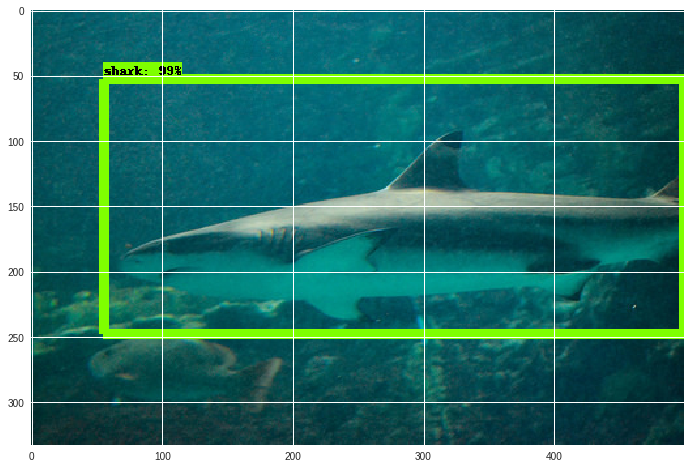

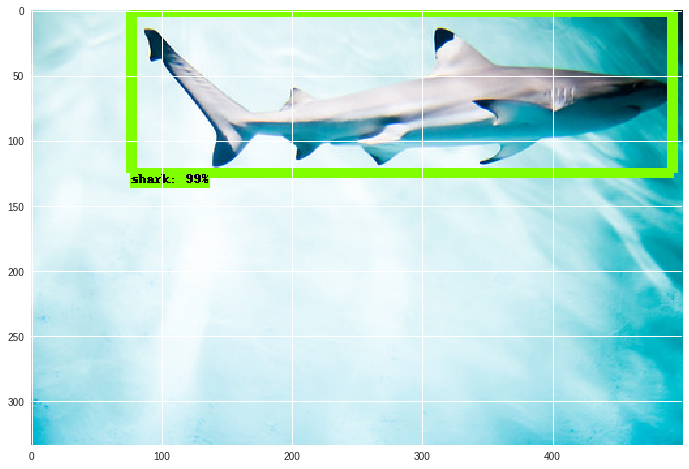

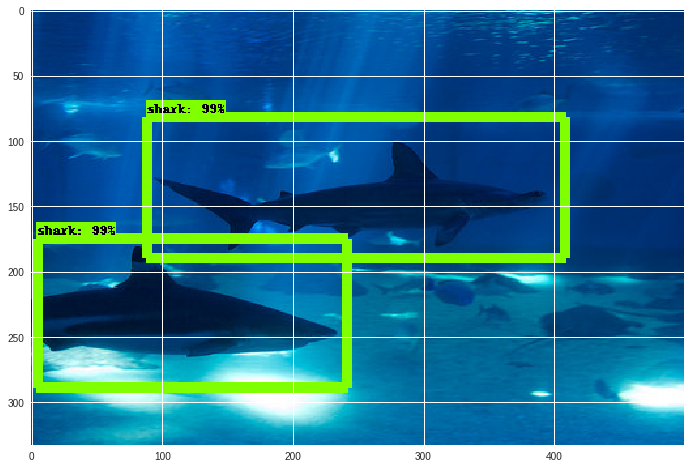

In [42]:
# test on couple images and see the results
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)

In [0]:
#set up path of your Google Drive
Path_pred = '/content/drive/My Drive/shark_pulse/tensorflow_shark_detector_v1_workflow/output_image_crop/'

In [0]:
def detect_objects_crop(image_path, image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    print(scores[0][0])
    print(len(boxes.shape))
    
    # crop the bounding box
    if scores[0][0] >= 0.99:
      ymin = boxes[0,0,0]
      xmin = boxes[0,0,1]
      ymax = boxes[0,0,2]
      xmax = boxes[0,0,3]
      (im_height, im_width, channel) = image_np.shape
      (xminn, xmaxx, yminn, ymaxx) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
      cropped_image = tf.image.crop_to_bounding_box(image_np, int(yminn), int(xminn), int(ymaxx - yminn), int(xmaxx - xminn))
      sess = tf.Session()
      img_data = sess.run(cropped_image)
      sess.close()
      io.imsave(Path_pred + image_path[12:19] + '_crop.jpg', img_data)
      return img_data
    elif scores[0][0] < 0.99:
      return image_np


In [0]:
# Test on images# 
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'test_{}.png'.format(i)) for i in range(16, 17) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
          image = Image.open(image_path)
          image_np = load_image_into_numpy_array(image)
          image_process = detect_objects_crop(image_path, image_np, sess, detection_graph)
          print(image_process.shape)
          #plt.figure(figsize=IMAGE_SIZE)
          #plt.imshow(image_process)

**6. Run inference on videos, crop bounding box in each frame**

In [0]:
# install moviepy package
!pip install moviepy

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [0]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

** ------->  Re-start here**

In [0]:
# go to the directory stored videso on My Drive
%cd videos/
!ls

In [0]:
# Set up path to save frames from videos and prediction video with bounding boxes
frame_save_path = '/content/drive/My Drive/shark_pulse/tensorflow_shark_detector_v1_workflow/output_frame/'
video_box_save_path = '/content/drive/My Drive/shark_pulse/tensorflow_shark_detector_v1_workflow/output_video_box/'
Path_pred = '/content/drive/My Drive/shark_pulse/tensorflow_shark_detector_v1_workflow/output_video_crop/'
filename = 'GP030066_ALL'

interval_frame = 10
clip_sec_start = 79
clip_sec_end = 82
clip_length = clip_sec_end - clip_sec_start

In [0]:
# save video frame to My Drive
clip1 = VideoFileClip(os.path.join(filename + ".mp4")).subclip(clip_sec_start, clip_sec_end)
num_frame = len(list(clip1.iter_frames()))
print(num_frame)
frame_len = 1/(float(num_frame)/clip_length) # one frame length: 0.0125 sec
print(frame_len)

In [0]:
for i in range(0, num_frame, interval_frame):
  clip1.save_frame(os.path.join(frame_save_path + filename + '_{}.png').format(i), t= i*frame_len)
  print('process frame # ', i)

In [0]:
white_output = 'out.mp4'
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

In [0]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [0]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip = VideoFileClip(os.path.join("out.mp4"))
clip.write_videofile(os.path.join(video_box_save_path + filename + "_box.mp4"),bitrate="5000k")

In [0]:
#%cd ../..

In [0]:
def detect_objects_crop_video(i, image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    print(scores[0][0])
    #print(len(boxes.shape))
    
    # crop the bounding box
    if scores[0][0] >= 0.99:
      ymin = boxes[0,0,0]
      xmin = boxes[0,0,1]
      ymax = boxes[0,0,2]
      xmax = boxes[0,0,3]
      (im_height, im_width, channel) = image_np.shape
      (xminn, xmaxx, yminn, ymaxx) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
      cropped_image = tf.image.crop_to_bounding_box(image_np, int(yminn), int(xminn), int(ymaxx - yminn), int(xmaxx - xminn))
      sess = tf.Session()
      img_data = sess.run(cropped_image)
      sess.close()
      io.imsave(Path_pred + filename + '_crop_' + str(i) + '.jpg', img_data)
      return img_data
    elif scores[0][0] < 0.99:
      return image_np

In [0]:
PATH_TO_TEST_IMAGES_DIR = frame_save_path

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        #for image_path in TEST_IMAGE_PATHS:
        for i in range(0, num_frame, interval_frame):
          image_path = (os.path.join(PATH_TO_TEST_IMAGES_DIR, filename + '_{}.png'.format(i)))
          image = Image.open(image_path)
          image_np = load_image_into_numpy_array(image)
          image_process = detect_objects_crop_video(i, image_np, sess, detection_graph)
          print(image_process.shape)
          print('----- Finishing processing ', i ,' -----')
          #plt.figure(figsize=IMAGE_SIZE)
          #plt.imshow(image_process)